In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
train = pd.read_hdf('open30.h5') # pick just a single brick

In [5]:
train = train.drop(['data_ind', 'event_id'], axis = 1)

In [8]:
train.head(5)

,TX,TY,X,Y,Z,signal
0,-0.248382,0.072824,37014.070312,38318.898438,31032.0,0.0
1,0.768548,0.490205,46626.425781,15151.117188,72408.0,1.0
2,-0.132050,-0.049405,54031.640625,69132.320312,60771.0,0.0
3,0.260584,0.207106,56653.531250,35025.765625,43962.0,0.0
4,0.267597,0.111272,42231.714844,47199.027344,20688.0,0.0


In [482]:
train.shape

(6999733, 6)

In [483]:
train_1 = train[train["signal"] == 1].sample(n = 100)
train_0 = train[train["signal"] == 0].sample(n = 200)


In [484]:
frames = [train_0, train_1]
train = pd.concat(frames)
train.shape

(300, 6)

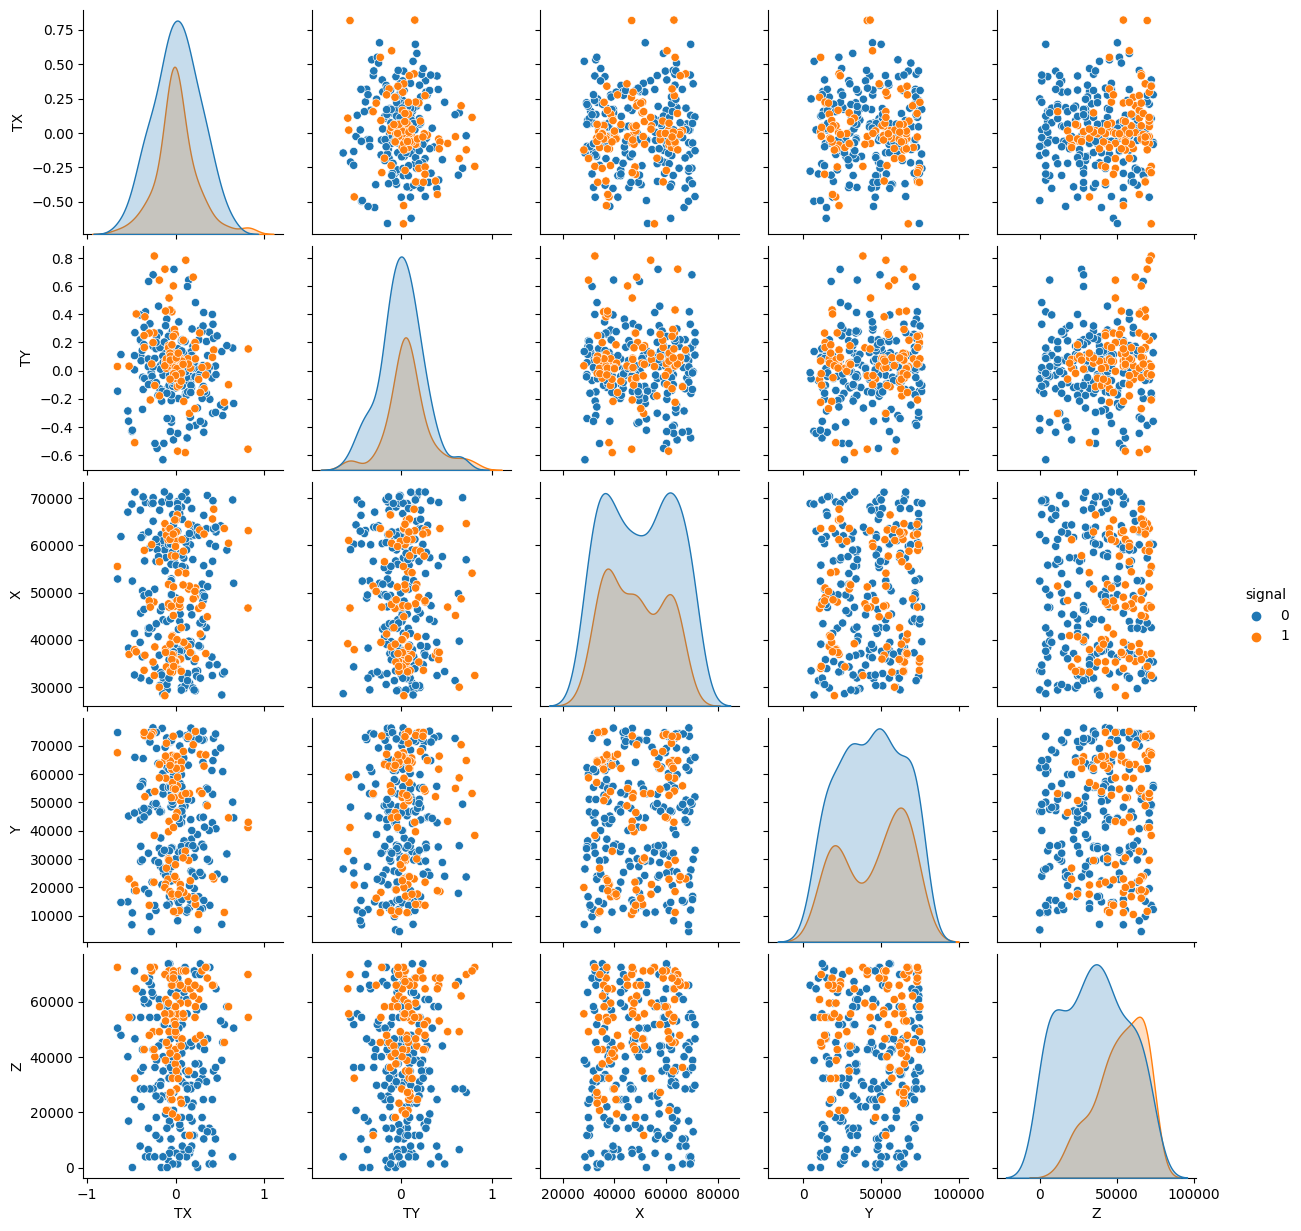

In [324]:
#sns.pairplot(train, hue="signal", palette="tab10")

In [508]:
with open('dark_matter_training_300observations.npy', 'wb') as f:
    np.save(f, train, allow_pickle=True)

In [485]:
#train.head(2)

In [486]:
#train['signal']

In [487]:
train['signal'] = train['signal'].astype('int')

In [488]:
labels = train['signal']

In [489]:
features = train[train.columns[0:5]]

In [490]:
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

In [491]:
features

array([[0.43404305, 0.52712303, 0.01703501, 0.52538216, 0.0877193 ],
       [0.47730362, 0.43222415, 0.49798673, 0.7844769 , 0.9649123 ],
       [0.2878791 , 0.6448461 , 0.34550542, 0.29614282, 0.15789473],
       ...,
       [0.47887477, 0.54237187, 0.25584602, 0.20767228, 0.6666666 ],
       [0.46927088, 0.6178997 , 0.4151588 , 0.671422  , 0.84210527],
       [0.01130185, 0.34361097, 0.36998397, 0.48409408, 0.71929824]],
      dtype=float32)

In [492]:
labels

5575783    0
5486775    0
1897327    0
6356702    0
1975484    0
          ..
2611251    1
4302778    1
5928869    1
2312303    1
4563628    1
Name: signal, Length: 300, dtype: int64

In [493]:
labels_1 = np.array(labels)

In [494]:
from sklearn.model_selection import train_test_split
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels_1, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [495]:
#train_labels[100]

0

In [496]:
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(train_features, train_labels) 

In [497]:
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.75
Classical SVC on the test dataset:     0.70


In [498]:
#num_features = features.shape[1]
#num_features

5

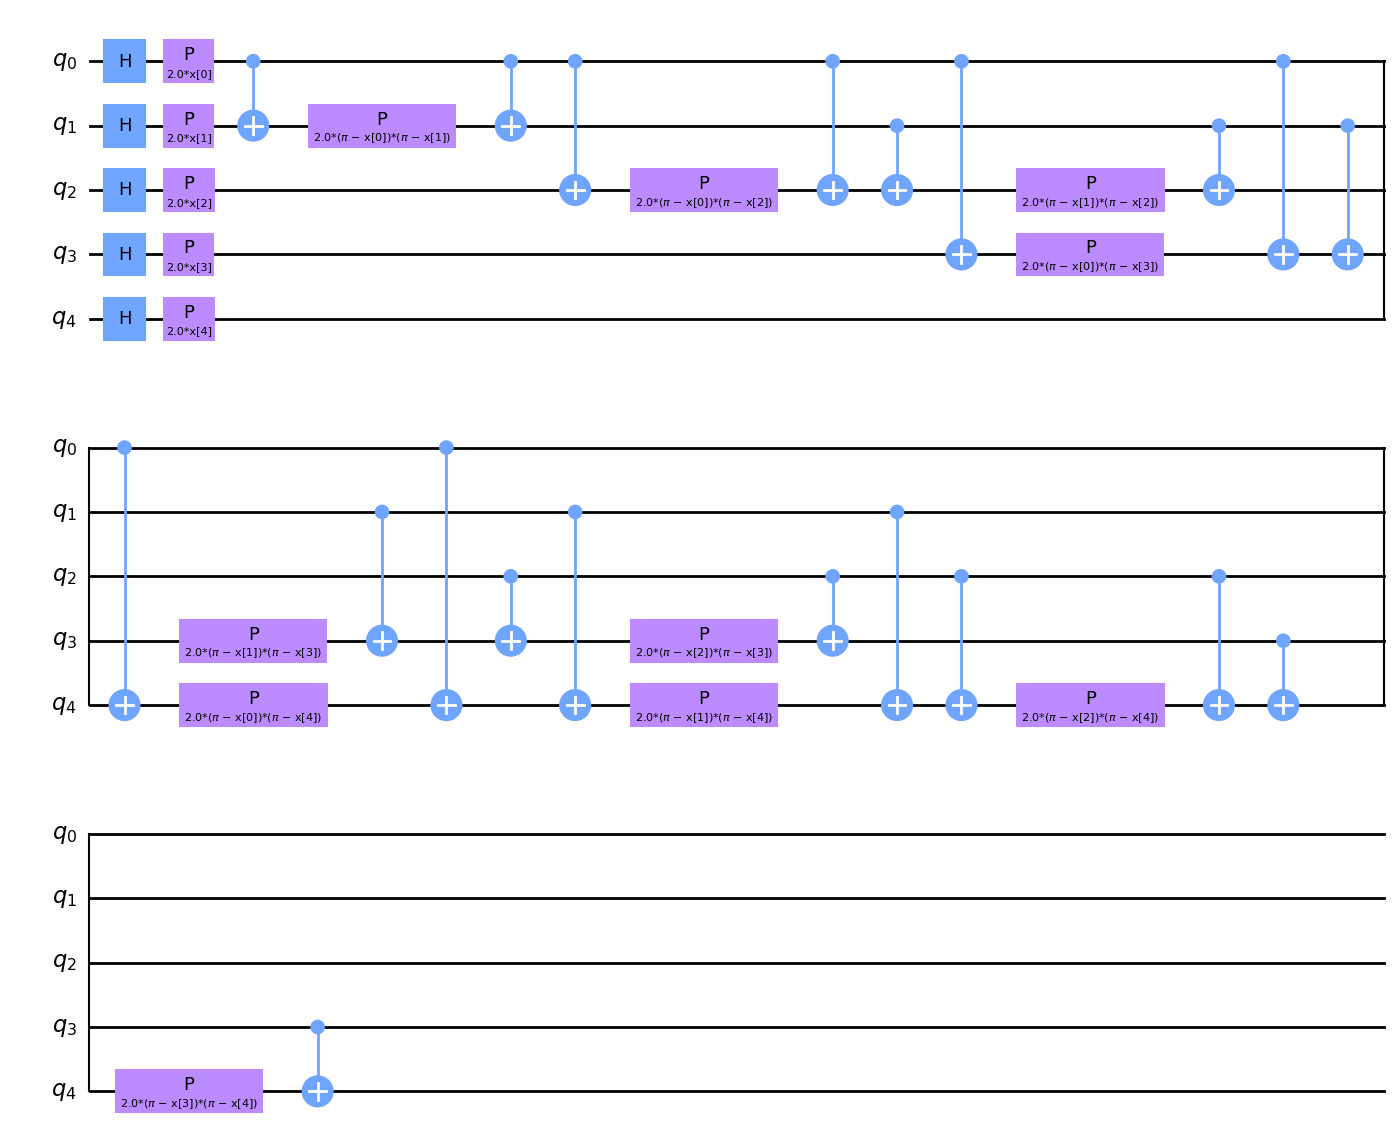

In [499]:
from qiskit.circuit.library import ZZFeatureMap

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

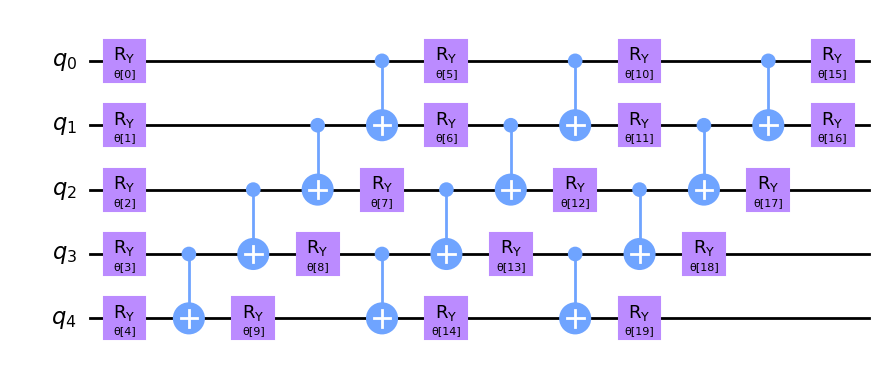

In [500]:
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit.library import EfficientSU2


ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
#ansatz = EfficientSU2(num_qubits=num_features, reps=3)

ansatz.decompose().draw(output="mpl", fold=20)

In [502]:
from qiskit.algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

In [503]:
from qiskit.primitives import Sampler

sampler = Sampler()

In [504]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()


In [505]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC


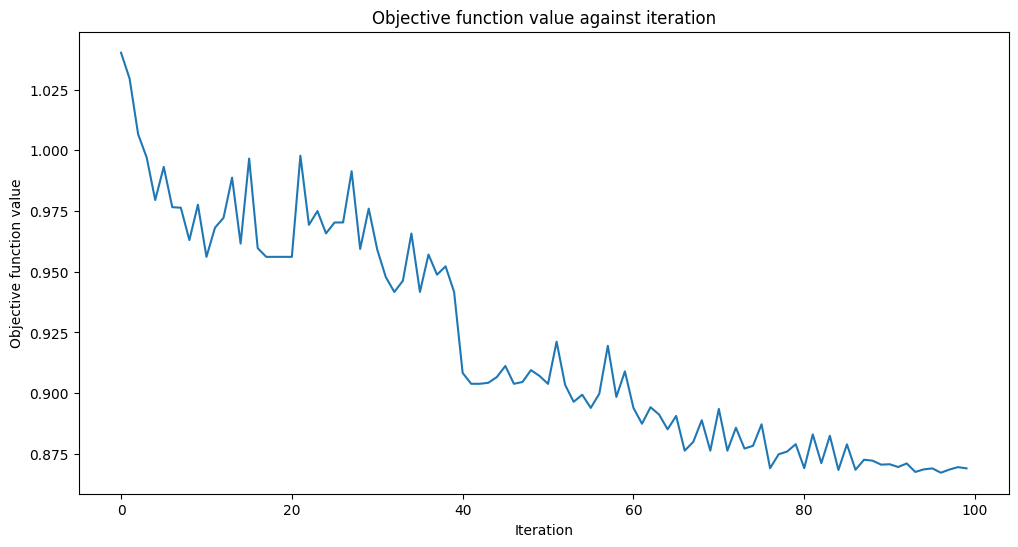

Training time: 345 seconds


In [506]:

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)


# clear objective value history
objective_func_vals = []

start = time.time()

vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")


In [507]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.75
Quantum VQC on the test dataset:     0.72


In [9]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright